In [1]:
#!/usr/bin/env python

# 4km_comgrid_comparison.ipynb

In [2]:
'''
This program reads in data from the MCS simulations on the common grid
and analyzes if there are systematic differences and convergence

The program needs data that has been processed here:
projects/2019_ASR-MCS/programs/Common_Grid_Data/4km_Common-Grid-Data.ipynb
'''

'\nThis program reads in data from the MCS simulations on the common grid\nand analyzes if there are systematic differences and convergence\n\nThe program needs data that has been processed here:\nprojects/2019_ASR-MCS/programs/Common_Grid_Data/4km_Common-Grid-Data.ipynb\n'

In [3]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.crs as ccrs

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import wrf

import metpy
from metpy.calc import density
# from metpy.units import units
from metpy.units import units

In [4]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from metpy.plots import ctables
# READ AND PARSE HERE
dbzmap = ctables.registry.get_colortable('NWSReflectivity')
# dbzmap = ctables.registry.get_colortable('NWSStormClearReflectivity')


In [5]:
def disctance(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Approximate radius of earth in km
    R = 6373.0

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    
    return distance

In [6]:
def variogram_drafts(ww,
                    threshold,
                    lag_dist,
                    draft_num):

    from draft_functions import core_2d_properties, core_3d_properties, watersheding
    rgiObj_Struct=np.zeros((3,3,3)); rgiObj_Struct[:,:,:]=1
    lag_dist_c = (lag_dist[1:] + lag_dist[:-1]) / 2
    variogram = np.zeros((draft_num, len(lag_dist_c))); variogram[:] = np.nan
    
    if np.max(ww) >= threshold:
        
        ww_th = ww > threshold
        rgiObjectsUD, nr_objectsUD = ndimage.label(ww_th,structure=rgiObj_Struct[0,:,:])
        rgiObjectsUD = watersheding(ww,
                                     1,
                                     1)
        
        # find the maximum in drafts and select the top 20 drafts for further analysis
        
        Objects=ndimage.find_objects(rgiObjectsUD)
        draft_max = np.zeros((len(Objects))); draft_max[:] = np.nan
        for ii in range(len(Objects)):
            draft_act = np.copy(ww[Objects[ii]])
            draft_max[ii] = np.max(draft_act[rgiObjectsUD[Objects[ii]] == ii+1])
        
        draft_id = np.argsort(draft_max)[::-1][:draft_num]
        
        
        for dr in range(np.min([draft_num, len(draft_id)])):
            # find location of draft maximum
            draft_act = np.copy(ww)
            draft_act[rgiObjectsUD != draft_id[dr]+1] = 0
            max_loc = np.where(draft_act == np.max(draft_act))
            max_val = draft_max[draft_id[dr]]
            
            dist = disctance(lat[max_loc[0][0], max_loc[1][0]],
                    lon[max_loc[0][0], max_loc[1][0]],
                    lat,
                    lon)
            for dd in range(len(lag_dist_c)):
                points = (dist >= lag_dist[dd]) & (dist < lag_dist[dd+1])
                variogram[dr,dd] = np.var(ww[points] - max_val)
    return variogram

In [7]:
# from draft_functions import core_2d_properties, core_3d_properties, \
#                             watersheding, interpolate_obs, remove_noise

In [8]:
# DX = ['500M','250M','125M']
# DT = [2,1,0.5]
# dx_m = [500,250,125] 

DX_all = ['4KM','2KM','1KM','500M','250M','125M'] #,'obs']
colors = ['#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c']
color_cortype = ['#e41a1c', '#377eb8', '#33a02c']
dx_km = [4,2,1,0.5,0.25,0.125]
DT_all = [16,8,4,2,1,0.5]
dx_m_all = [4000,2000,1000,500,250,125]

# for variogram calculatoin
lag_dist = np.arange(0,104,4)
draft_num = 20
threshold = 1.5

SIM_All = ['mao_20140401_15:00:00_', #125 | 0
        'mao_20140917_17:00:00_',
        'mao_20141004_13:00:00_',
        'mao_20141018_14:00:00_',
        'mao_20141117_18:00:00_',
        'mao_20141210_14:00:00_',
        'mao_20150328_15:00:00_',
        'mao_20150412_12:00:00_',
        'mao_20150621_14:00:00_',
        'mao_20151106_12:00:00_', #125 | 9
        'sgp_20120531_04:00:00_',
        'sgp_20120615_07:00:00_', #125 | 11
        'sgp_20130509_07:00:00_',
        'sgp_20130605_09:00:00_',
        'sgp_20130617_07:00:00_',
        'sgp_20140602_04:00:00_',
        'sgp_20140605_12:00:00_',
        'sgp_20140612_06:00:00_', #125 | 17
        'sgp_20140628_16:00:00_',
        'sgp_20140710_10:00:00_']
    
wrfout_dir = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/Coarsened_Data/4km_more-vars/'
save_dir = '/glade/campaign/mmm/c3we/prein/Projects/2019_ASR-MCS/data/Coarsened_Data/processed_data/'

colors = ['#1f78b4','#a6cee3','#33a02c','#ff7f00','#fb9a99','#e31a1c']

In [9]:
# if Site == 'SGP':
#     proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/sgp_20120531_04:00:00_L4/wrfout_d01_2012-05-30_04:00:00'
#     extension = [-111, -88, 28, 48]
#     ARMlon = -97.4882
#     ARMlat = 36.6077
# if Site == 'MAO':
#     proj_File = '/glade/campaign/mmm/c3we/mingge/WRFV4.1.5_intel_dmpar/Thomson_YSU/mao_20150303_20:00:00_L4/wrfout_d01_2015-03-02_20:00:00'
#     extension = [-69, -49, -13.5,6]
#     ARMlon = -60.025
#     ARMlat = -3.113

### Read in W and Z at time t_foc

In [10]:
# define matrices to store the processed data
# diabatic_heating_all = np.zeros((72,95, len(SIM_All), len(DX_all))); diabatic_heating_all[:] = np.nan
# massflux_up_all = np.copy(diabatic_heating_all)
# massflux_down_all = np.copy(diabatic_heating_all)
# q_frozen_all = np.copy(diabatic_heating_all)
# q_graupel_all = np.copy(diabatic_heating_all)
# q_liquid_all = np.copy(diabatic_heating_all)
# thetae_all = np.copy(diabatic_heating_all)

variables = ['diabatic heating', 
             'upward mass flux',
            'downward mass flux',
            'frozen mixing ratio',
            'grapel mixing ratio',
            'liquid mixing ratio',
            'Theta E']
areal_av = np.zeros((72,95, len(SIM_All), len(DX_all), len(variables))); areal_av[:] = np.nan

pr_all = np.zeros((72,187,187, len(SIM_All), len(DX_all))); pr_all[:] = np.nan

variograms = np.zeros((72, 95, draft_num, len(lag_dist)-1, len(SIM_All), len(DX_all), 2)); variograms[:] = np.nan

In [11]:
for si in range(len(SIM_All)):
    save_sim = save_dir+SIM_All[si]+'_4km-comgrid_analysis.npz'
    if os.path.isfile(save_sim) == False:
        areal_av_sim = np.copy(areal_av[:,:,si,:])
        pr_sim = np.copy(pr_all[:,:,:,si,:])
        variograms_sim = np.copy(variograms[:,:,:,:,si,:])
        SIM = SIM_All[si]
        print(SIM)
    
        if SIM[:3] == 'sgp':
            #  location of SGP site
            ARMlon = -97.4882
            ARMlat = 36.6077
            mean_height = np.array([   69.,   131.,   210.,   310.,   436.,   593.,   785.,  1020.,
                            1294.,  1583.,  1870.,  2154.,  2435.,  2714.,  2991.,  3266.,
                            3538.,  3809.,  4078.,  4345.,  4610.,  4874.,  5137.,  5398.,
                            5658.,  5916.,  6173.,  6429.,  6684.,  6938.,  7190.,  7441.,
                            7692.,  7941.,  8189.,  8436.,  8681.,  8926.,  9170.,  9412.,
                            9654.,  9894., 10134., 10372., 10609., 10846., 11081., 11315.,
                            11547., 11778., 12007., 12235., 12460., 12684., 12906., 13127.,
                            13346., 13563., 13779., 13993., 14208., 14422., 14636., 14851.,
                            15065., 15280., 15494., 15709., 15923., 16137., 16352., 16566.,
                            16780., 16994., 17208., 17422., 17636., 17850., 18064., 18277.,
                            18491., 18705., 18918., 19132., 19346., 19560., 19773., 19987.,
                            20201., 20415., 20629., 20843., 21057., 21271., 21485.])
        elif SIM[:3] == 'mao':
            #  location of Mao site
            ARMlon = -60.025
            ARMlat = -3.113 
            mean_height = np.array([   37.,    99.,   180.,   281.,   409.,   569.,   766.,  1007.,
                            1290.,  1589.,  1887.,  2183.,  2476.,  2768.,  3058.,  3346.,
                            3633.,  3917.,  4200.,  4481.,  4760.,  5038.,  5314.,  5588.,
                            5860.,  6131.,  6400.,  6668.,  6934.,  7198.,  7461.,  7722.,
                            7981.,  8239.,  8495.,  8750.,  9003.,  9254.,  9504.,  9752.,
                            9998., 10243., 10486., 10727., 10967., 11205., 11442., 11677.,
                            11910., 12141., 12371., 12598., 12824., 13049., 13271., 13491.,
                            13710., 13927., 14143., 14357., 14570., 14784., 14997., 15210.,
                            15423., 15636., 15849., 16061., 16274., 16487., 16699., 16912.,
                            17124., 17337., 17549., 17762., 17975., 18187., 18400., 18613.,
                            18826., 19039., 19252., 19465., 19678., 19891., 20104., 20317.,
                            20530., 20743., 20957., 21170., 21383., 21597., 21810.])
        
        for dx in tqdm(range(len(DX_all))):
            print(DX_all[dx])
        
            if np.isin(DX_all[dx], ('500M','250M','125M')) == True:
                subkm = True
            else:
                subkm = False
        
            if subkm == True:
                wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d02*'))
            else:
                if DX_all[dx] != '12KM':
                    wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d01*'))
                else:
                    wrfout_files = np.sort(glob.glob(wrfout_dir+DX_all[dx]+'/'+SIM+'L/wrfout_d01*'))
                # only focus the analysis on 18 - 30 hours 
                wrfout_files = wrfout_files[18*6+1:18*6+1+12*6]
    
            for hh in range(len(wrfout_files)):
                # read in key variables at t_foc
                ncfile = Dataset(wrfout_files[hh])
                HGT = np.array(getvar(ncfile, "HGT"))
                lat = np.squeeze(ncfile.variables["XLAT"])
                lon = np.squeeze(ncfile.variables['XLONG'])
                dbz = np.squeeze(ncfile.variables["REFL_10CM"][:,:,:,:])
                ww = np.squeeze(ncfile.variables["W"][:,:,:,:])
                zz = (np.squeeze(ncfile.variables["PHB"][:,:,:,:]) + np.squeeze(ncfile.variables["PH"][:,:,:,:]))/9.81 - HGT[None,:]
                pp = np.squeeze(ncfile.variables["P"][:,:,:,:]) + np.squeeze(ncfile.variables["PB"][:,:,:,:])
                tt = np.squeeze(ncfile.variables["T"][:,:,:,:])
                qv = np.squeeze(ncfile.variables["QVAPOR"][:,:,:,:])
                qi = np.squeeze(ncfile.variables["QICE"][:,:,:,:])
                qg = np.squeeze(ncfile.variables["QGRAUP"][:,:,:,:])
                qr = np.squeeze(ncfile.variables["QRAIN"][:,:,:,:])
                qs = np.squeeze(ncfile.variables["QSNOW"][:,:,:,:])
                qc = np.squeeze(ncfile.variables["QCLOUD"][:,:,:,:])
                if 'H_DIABATIC' in ncfile.variables.keys():
                    diab_heat = np.squeeze(ncfile.variables["H_DIABATIC"][:,:,:,:])
                    RTHRATSW = np.squeeze(ncfile.variables["RTHRATSW"][:,:,:,:])
                    RTHRATLW = np.squeeze(ncfile.variables["RTHRATLW"][:,:,:,:])
                if SIM[:3] == 'sgp':
                    pr_sim[hh,:,:,dx] = np.squeeze(ncfile.variables["RAINNC"][:,:-1,:-1])
                else:
                    pr_sim[hh,:,:,dx] = np.squeeze(ncfile.variables["RAINNC"][:,:,:])
                ncfile.close()
    
                tk = wrf.tk(pp, tt+300, meta=False, units='K')
                ww_cent = (ww[:-1,:] + ww[1:,:]) / 2
                zz_cent = (zz[:-1,:] + zz[1:,:]) / 2
                
                # calculate air density
                pp = units.Quantity(pp, "Pa")
                tk = units.Quantity(tk, "degK")
                qtot = units.Quantity(((qv+qi+qs+qg+qc+qr) * 1000), 'g/kg')
                
                dens_moist = density(pp, 
                                   tk, 
                                   qtot)
    
                # calculate theta-e
                qv = units.Quantity((qv * 1000), 'g/kg')
                p_vap = metpy.calc.vapor_pressure(pp, qv)
                dewpoint = metpy.calc.dewpoint(p_vap)
                thetae = metpy.calc.equivalent_potential_temperature(pp, tk, dewpoint)

                # calculate variogram of vertical wind speed

                # Vertical mass transport
                ww_up = np.copy(ww_cent)
                ww_up[ww_up < 0] = 0
                vert_mass_up = dens_moist * ww_up * 4000**2 
                ww_down = np.copy(ww_cent)
                ww_down[ww_down > 0] = 0
                vert_mass_down = dens_moist * ww_down * 4000**2
    
                # interpolate to common height grid
                vert_mass_up_int = np.array(wrf.interpz3d(np.array(vert_mass_up), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                vert_mass_up_int[vert_mass_up_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('upward mass flux')] = np.mean(vert_mass_up_int, axis=(1,2))
                
                vert_mass_down_int = np.array(wrf.interpz3d(np.array(vert_mass_down), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                vert_mass_down_int[vert_mass_down_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('downward mass flux')] = np.mean(vert_mass_down_int, axis=(1,2))
    
                if 'H_DIABATIC' in ncfile.variables.keys():
                    diab_heat_int = np.array(wrf.interpz3d(np.array(diab_heat), 
                                                     np.array(zz_cent), 
                                                     np.array(mean_height)))
                    diab_heat_int[diab_heat_int > 10**10] = np.nan
                    areal_av_sim[hh,:,dx,variables.index('diabatic heating')] = np.nanmean(diab_heat_int, axis=(1,2))
    
                qgraup_int = np.array(wrf.interpz3d(np.array(qg), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                qgraup_int[qgraup_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('grapel mixing ratio')] = np.mean(qgraup_int, axis=(1,2))
    
                qfrozen_int = np.array(wrf.interpz3d(np.array((qg+qi+qs)), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                qfrozen_int[qfrozen_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('frozen mixing ratio')] = np.mean(qfrozen_int, axis=(1,2))
    
                qliquid_int = np.array(wrf.interpz3d(np.array((qc+qr)), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                qliquid_int[qliquid_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('liquid mixing ratio')] = np.mean(qliquid_int, axis=(1,2))
    
                thetae_int = np.array(wrf.interpz3d(np.array(thetae), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                thetae_int[thetae_int > 10**10] = np.nan
                areal_av_sim[hh,:,dx,variables.index('Theta E')] = np.mean(thetae_int, axis=(1,2))

                # calculate variogram
                ww_int = np.array(wrf.interpz3d(np.array(ww_cent), 
                                                 np.array(zz_cent), 
                                                 np.array(mean_height)))
                ww_int[ww_int > 10**10] = np.nan
                for lev in range(ww_int.shape[0]):
                    # updrafts
                    variograms_sim[hh, lev,:,:,dx,0] = \
                    variogram_drafts(ww_int[lev,:,:],
                                            threshold,
                                            lag_dist,
                                            draft_num)
                    # downdrafts
                    variograms_sim[hh, lev,:,:,dx,1] = \
                    variogram_drafts(ww_int[lev,:,:]*-1,
                                            threshold,
                                            lag_dist,
                                            draft_num)
        
        np.savez(save_sim,
                areal_av_sim = areal_av_sim,
                pr_sim = pr_sim,
                variograms_sim = variograms_sim)
    else:
        data = np.load(save_sim)
        areal_av_sim = data['areal_av_sim']
        pr_sim = data['pr_sim']
        variograms_sim = data['variograms_sim']

    areal_av[:,:,si,:] = areal_av_sim
    pr_all[:,:,:,si,:] = pr_sim
    variograms[:,:,:,:,si,:] = variograms_sim


100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Variogram_drafts_4-km_comgrid.pdf


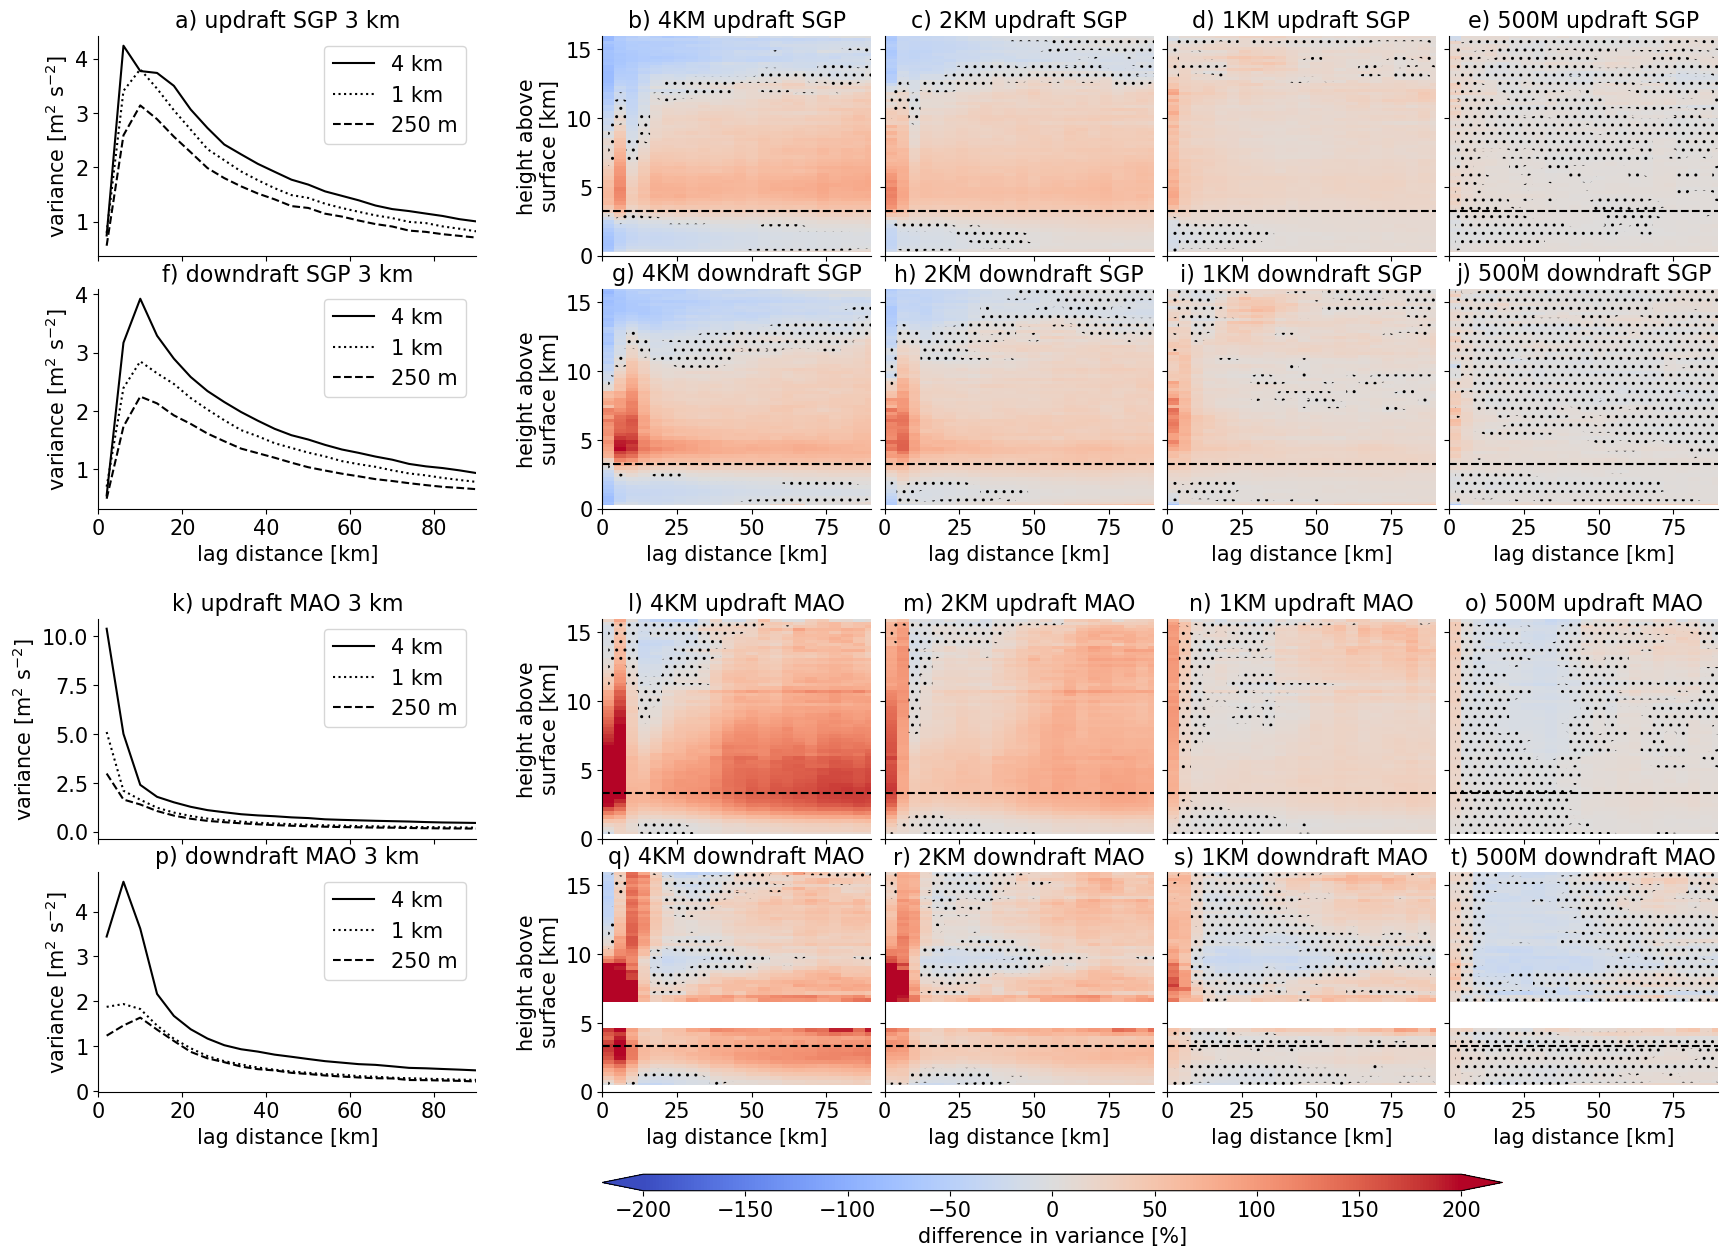

In [12]:
dir = 0
si = [0,10]
regions = ['SGP', 'MAO']
directions = ['updraft', 'downdraft']
lag_dist_c = (lag_dist[1:] + lag_dist[:-1])/2

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

fig = plt.figure(figsize=(18,11))


for re in range(len(regions)):
    gs1 = gridspec.GridSpec(2,4)
    gs2 = gridspec.GridSpec(2,1)
    if regions[re] == 'SGP':
        #  location of SGP site
        si = [10,20]
        gs1.update(left=0.35, right=0.97,
                   bottom=0.55, top=0.98,
                   wspace=0.05, hspace=0.15)
        gs2.update(left=0.07, right=0.28,
                   bottom=0.55, top=0.98,
                   wspace=0.05, hspace=0.15)
        mean_height = np.array([   69.,   131.,   210.,   310.,   436.,   593.,   785.,  1020.,
                        1294.,  1583.,  1870.,  2154.,  2435.,  2714.,  2991.,  3266.,
                        3538.,  3809.,  4078.,  4345.,  4610.,  4874.,  5137.,  5398.,
                        5658.,  5916.,  6173.,  6429.,  6684.,  6938.,  7190.,  7441.,
                        7692.,  7941.,  8189.,  8436.,  8681.,  8926.,  9170.,  9412.,
                        9654.,  9894., 10134., 10372., 10609., 10846., 11081., 11315.,
                        11547., 11778., 12007., 12235., 12460., 12684., 12906., 13127.,
                        13346., 13563., 13779., 13993., 14208., 14422., 14636., 14851.,
                        15065., 15280., 15494., 15709., 15923., 16137., 16352., 16566.,
                        16780., 16994., 17208., 17422., 17636., 17850., 18064., 18277.,
                        18491., 18705., 18918., 19132., 19346., 19560., 19773., 19987.,
                        20201., 20415., 20629., 20843., 21057., 21271., 21485.])
    elif regions[re] == 'MAO':
        #  location of Mao site
        si = [0,10]
        gs1.update(left=0.35, right=0.97,
                   bottom=0.02, top=0.45,
                   wspace=0.05, hspace=0.15)
        gs2.update(left=0.07, right=0.28,
                   bottom=0.02, top=0.45,
                   wspace=0.05, hspace=0.15)
        mean_height = np.array([   37.,    99.,   180.,   281.,   409.,   569.,   766.,  1007.,
                        1290.,  1589.,  1887.,  2183.,  2476.,  2768.,  3058.,  3346.,
                        3633.,  3917.,  4200.,  4481.,  4760.,  5038.,  5314.,  5588.,
                        5860.,  6131.,  6400.,  6668.,  6934.,  7198.,  7461.,  7722.,
                        7981.,  8239.,  8495.,  8750.,  9003.,  9254.,  9504.,  9752.,
                        9998., 10243., 10486., 10727., 10967., 11205., 11442., 11677.,
                        11910., 12141., 12371., 12598., 12824., 13049., 13271., 13491.,
                        13710., 13927., 14143., 14357., 14570., 14784., 14997., 15210.,
                        15423., 15636., 15849., 16061., 16274., 16487., 16699., 16912.,
                        17124., 17337., 17549., 17762., 17975., 18187., 18400., 18613.,
                        18826., 19039., 19252., 19465., 19678., 19891., 20104., 20317.,
                        20530., 20743., 20957., 21170., 21383., 21597., 21810.])

    variograms_nan = np.copy(variograms)
    # set values to nan for areas that have less than 5 drafts sampled
    nan = np.sum(~np.isnan(variograms[:,:,:,:]), axis=2) < 5
    for ii in range(variograms.shape[2]):
        variograms_nan[:,:,ii][nan] = np.nan
    
    # calculate temporal mean only if more than 5 time steps have valid data
    variograms_tav = np.nanmean(variograms_nan, axis = 0)
    t_samples = np.sum(~np.isnan(variograms_nan), axis = 0)
    variograms_tav[t_samples < 5] = np.nan
    
    # calculate average over samples and set areas to nan that have less than 5 sims
    variograms_tav_ensav = np.nanmean(variograms_tav[:,:,:,si[0]:si[1],:,:], axis = 3)
    ens_sampels = np.sum(~np.isnan(variograms_tav[:,:,:,si[0]:si[1],:,:]), axis = 3)
    variograms_tav_ensav[ens_sampels < 3] = np.nan
    
    for dir in range(len(directions)):
        # plot line plot show show raw data at height level
        ax2 = plt.subplot(gs2[dir,0])
        if regions[re] == 'SGP':
            lev = 15
        else:
            lev = 15
        plt.plot(lag_dist_c, np.nanmean(variograms_tav_ensav[lev,si[0]:si[1],:,0,dir], axis=(0)), 
                 c='k', label = '4 km')
        plt.plot(lag_dist_c, np.nanmean(variograms_tav_ensav[lev,si[0]:si[1],:,2,dir], axis=(0)), 
                 c='k', ls=':', label = '1 km')
        plt.plot(lag_dist_c, np.nanmean(variograms_tav_ensav[lev,si[0]:si[1],:,4,dir], axis=(0)), 
                 c='k', ls='--', label = '250 m')
        ax2.set_title(rgsLableABC[dir*5+re*10]+') '+directions[dir]+ ' ' + regions[re]+' '+str(int(mean_height[lev]/1000.))+' km', fontsize=16)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_color('k')
        ax2.spines['bottom'].set_color('k')
        ax2.set_ylabel('variance [m$^2$ s$^{-2}$]')
        if dir == 1:
            ax2.set_xlabel('lag distance [km]')
        else:
            ax2.set_xticklabels([])
        ax2.set_xlim([0,90])
        plt.legend()
        
        for dx in tqdm(range(4)):
            ax = plt.subplot(gs1[dir,dx])

            cs_b = plt.pcolormesh(lag_dist_c,
                           mean_height/1000.,
                           ((np.nanmean(variograms_tav_ensav[:,si[0]:si[1],:,dx,dir], axis=1)-
                           np.nanmean(variograms_tav_ensav[:,si[0]:si[1],:,4,dir], axis=1))/
                           np.nanmean(variograms_tav_ensav[:,si[0]:si[1],:,4,dir], axis=1)) *100.,
                          cmap='coolwarm', vmin=-200, vmax=200)

            # check for significance
            sig_diff = np.zeros((variograms_tav_ensav.shape[0], variograms_tav_ensav.shape[2])); sig_diff[:] = np.nan
            for hh in range(variograms_tav_ensav.shape[0]):
                for xx in range(variograms_tav_ensav.shape[2]):
                    high_res = variograms_tav_ensav[hh,si[0]:si[1],xx,4,dir]
                    high_res = high_res[~np.isnan(high_res)]
                    low_res = variograms_tav_ensav[hh,si[0]:si[1],xx,dx,dir]
                    low_res = low_res[~np.isnan(low_res)]
                    if (len(high_res) > 3) & (len(low_res) > 3):
                        sig_diff[hh,xx] = scipy.stats.mannwhitneyu(high_res, low_res)[1]
            plt.contourf(lag_dist_c,
                        mean_height/1000.,
                        sig_diff > 0.05 ,
                        hatches=['', '..'],  alpha=0)
            plt.axhline(y=mean_height[15]/1000., color='k', linestyle='--')
            
            ax.set_ylim([0,16])
            ax.set_xlim([0,90])
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_color('k')
            ax.spines['bottom'].set_color('k')
            if dx == 0:
                ax.set_ylabel('height above\nsurface [km]')
            else:
                ax.set_yticklabels([])
            if dir == 1:
                ax.set_xlabel('lag distance [km]')
            else:
                ax.set_xticklabels([])
            
            ax.set_title(rgsLableABC[dx + dir*4 + 8*re + (1+dir+re*2)]+') '+DX_all[dx]+' '+directions[dir]+ ' ' + regions[re], fontsize=16)


CbarAx = plt.axes([0.35, -0.070, 0.5, 0.015])
cb = plt.colorbar(cs_b, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=np.linspace(0,0.0015,41))
# cb.ax.set_xticklabels(LEVS,rotation=90)
cb.set_label('difference in variance [%]') #, fontsize=12)

sPlotFile=''
sPlotName= 'Variogram_drafts_4-km_comgrid.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)
plt.show()

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: Domain_average-profiles_4-km_comgrid.pdf


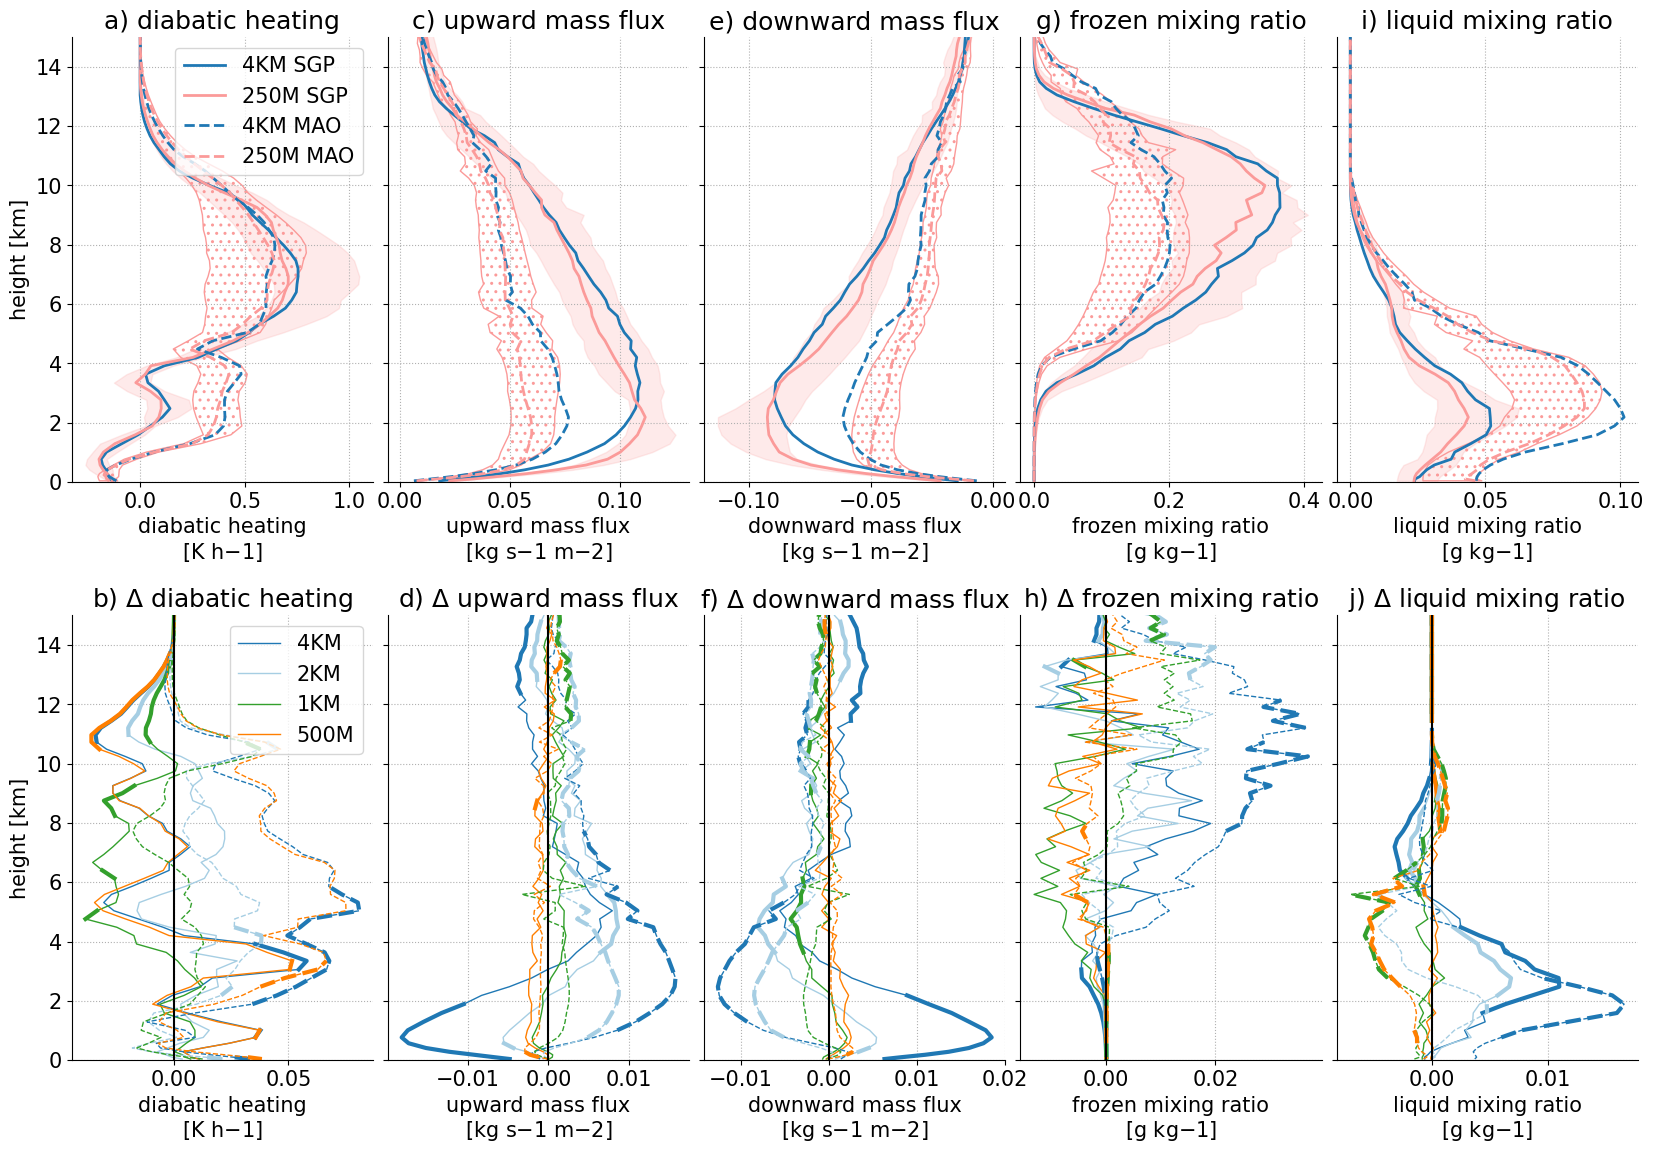

In [23]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 15})
rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

selstat = ['diabatic heating',
          'upward mass flux',
          'downward mass flux',
           'frozen mixing ratio',
           'liquid mixing ratio']
units = ['K h${-1}$', 'kg s${-1}$ m${-2}$', 'kg s${-1}$ m${-2}$','g kg${-1}$','g kg${-1}$']
skaling = [1/3600,4000**2,4000**2,1/1000,1/1000]

# variables = ['diabtic heating', 
#              'upward mass flux',
#             'downward mass flux',
#             'frozen mixing ratio',
#             'grapel mixing ratio',
#             'liquid mixing ratio',
#             'Theta E']

fig = plt.figure(figsize=(18,11))
gs1 = gridspec.GridSpec(2,len(selstat))
gs1.update(left=0.1, right=0.97,
                   bottom=0.02, top=0.95,
                   wspace=0.05, hspace=0.3)

for st in range(len(selstat)):
    stat = selstat[st]
    
    ax = plt.subplot(gs1[0,st])
    for re in range(len(regions)):
        if regions[re] == 'SGP':
            si = [10,20]
            ls = '-'
        else:
            si = [0,10]
            ls = '--'
            
        time_mean = np.nanmedian(areal_av[:,:,:,:, variables.index(stat)], axis=(0))/ skaling[st]
        
        for dx in [0, len(DX_all)-2]:
            plt.plot(np.nanmedian(time_mean[:,si[0]:si[1],dx], axis=(1)), 
                     mean_height/1000., 
                     c=colors[dx],
                    ls = ls,
                    lw=2,
                    label = str(DX_all[dx])+' '+regions[re])
            if DX_all[dx] == '250M':
                if regions[re] == 'SGP':
                    plt.fill_betweenx(x1 = np.nanpercentile(time_mean[:,si[0]:si[1],dx], 25, axis=(1)), 
                                  x2 = np.nanpercentile(time_mean[:,si[0]:si[1],dx], 75, axis=(1)), 
                                  y = mean_height/1000,
                                  color=colors[dx],
                                  zorder = -1,
                                 alpha = 0.2)
                else:
                    plt.fill_betweenx(x1 = np.nanpercentile(time_mean[:,si[0]:si[1],dx], 25, axis=(1)), 
                                  x2 = np.nanpercentile(time_mean[:,si[0]:si[1],dx], 75, axis=(1)), 
                                  y = mean_height/1000,
                                  zorder = -1,
                                  color="none",hatch="..",edgecolor=colors[dx])
    ax.set_ylim([0,15])
    ax.set_xlabel(selstat[st] + '\n['+units[st]+']')
    if st == 0:
        ax.set_ylabel('height [km]')
        plt.legend()
    else:
        ax.set_yticklabels([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('k')
    ax.spines['bottom'].set_color('k')
    plt.grid(alpha = 1, ls = ':')
    plt.title(rgsLableABC[st*2]+') '+selstat[st])

    # -------------------------------
    ### plot differences between dx
    ax = plt.subplot(gs1[1,st])
    for re in range(len(regions)):
        time_mean = np.nanmedian(areal_av[:,:,:,:, variables.index(stat)], axis=(0)) 
        
        if regions[re] == 'SGP':
            si = [10,20]
            ls = '-'
        else:
            si = [0,10]
            ls = '--'
        for dx in range(len(DX_all)-2):
            diff_members = time_mean[:,si[0]:si[1],dx] - time_mean[:,si[0]:si[1],4]
            p_vals = np.zeros((len(mean_height))); p_vals[:] = np.nan
            for lev in range(len(mean_height)):
                try:
                    refe = time_mean[lev,si[0]:si[1],dx]
                    cont = time_mean[lev,si[0]:si[1],4]
                    fin = ~np.isnan(refe)
                    p_vals[lev] = scipy.stats.wilcoxon(refe[fin], cont[fin])[1]
                except:
                    continue
            
            mean_diff = np.nanmean(diff_members[:,:], axis=(1)) / skaling[st]
            plt.plot(mean_diff, 
                     mean_height/1000., 
                     c=colors[dx],
                     ls = ls,
                     lw=1)
            # Plot significant differences with thicker lines
            mean_diff[p_vals > 0.05] = np.nan
            plt.plot(mean_diff, 
                     mean_height/1000., 
                     c=colors[dx],
                     ls = ls,
                     lw=3)
            
    plt.axvline(x=0, c='k')
    ax.set_ylim([0,15]) 
    
    ax.set_xlabel(selstat[st] + '\n['+units[st]+']')
    if st == 0:
        ax.set_ylabel('height [km]')
    else:
        ax.set_yticklabels([])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('k')
    ax.spines['bottom'].set_color('k')
    plt.grid(alpha = 1, ls = ':')
    plt.title(rgsLableABC[st*2+1]+') $\Delta$ '+selstat[st])
    if st == 0:
        for dx in range(len(DX_all)-2):
            plt.plot([],[],
                     c=colors[dx],
                     label = DX_all[dx],
                     ls = '-',
                     lw=1)
        plt.legend()
    
# plt.xlim([326,330])

sPlotFile=''
sPlotName= 'Domain_average-profiles_4-km_comgrid.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)
plt.show()

In [14]:
p_vals

array([0.32226562, 0.27539062, 0.32226562, 0.10546875, 0.06445312,
       0.03710938, 0.01953125, 0.02734375, 0.06445312, 0.06445312,
       0.10546875, 0.08398438, 0.01953125, 0.00585938, 0.00390625,
       0.00390625, 0.00195312, 0.00195312, 0.00390625, 0.00195312,
       0.00195312, 0.00195312, 0.00195312, 0.00195312, 0.01367188,
       0.00976562, 0.06445312, 0.02734375, 0.84570312, 0.625     ,
       0.06445312, 0.00195312, 0.00195312, 0.00195312, 0.00195312,
       0.00195312, 0.00195312, 0.00195312, 0.00195312, 0.00195312,
       0.00195312, 0.00195312, 0.00195312, 0.00390625, 0.00195312,
       0.00768579, 0.10880943,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

In [15]:
np.nanmean(diff_members[:,:], axis=(1)) / skaling[st]

array([-7.38332801e-04, -4.46684544e-04, -4.88916385e-04, -8.83773373e-04,
       -1.15315647e-03, -1.28388501e-03, -1.28680476e-03, -1.53437277e-03,
       -1.42242143e-03, -1.33821804e-03, -1.49981734e-03, -1.89891998e-03,
       -2.71748559e-03, -3.45127974e-03, -4.12213012e-03, -4.50234984e-03,
       -4.83780641e-03, -5.24602474e-03, -5.03810752e-03, -5.15650272e-03,
       -5.42937223e-03, -4.85514156e-03, -3.17183831e-03, -5.02013104e-03,
       -2.57275860e-03, -3.37307465e-03, -1.14916859e-03, -8.92491107e-04,
       -2.13816929e-04,  1.04499850e-04,  5.27418922e-04,  1.02778732e-03,
        1.18444425e-03,  1.35475515e-03,  1.38269677e-03,  1.15231721e-03,
        1.32306009e-03,  1.13260871e-03,  9.34857962e-04,  7.43332541e-04,
        5.16868015e-04,  2.30277211e-04,  1.14120032e-04,  1.88670879e-05,
        3.42588932e-06,  7.94598651e-08,  1.90080089e-09,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [16]:
mean_diff = np.nanmean(diff_members[:,:], axis=(1)) / skaling[st]
plt.plot(mean_diff, 
         mean_height/1000., 
         c=colors[dx],
         ls = ls,
         lw=1)
# Plot significant differences with thicker lines
mean_diff[p_vals > 0.05] = np.nan
plt.plot(mean_diff, 
         mean_height/1000., 
         c=colors[dx],
         ls = ls,
         lw=3)

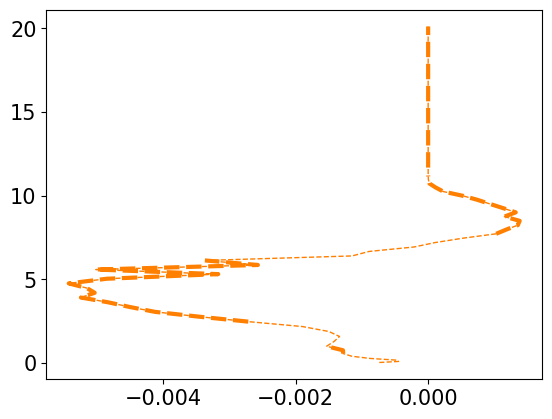

In [17]:
plt.show()

In [18]:
mean_diff

array([            nan,             nan,             nan,             nan,
                   nan, -1.28388501e-03, -1.28680476e-03, -1.53437277e-03,
                   nan,             nan,             nan,             nan,
       -2.71748559e-03, -3.45127974e-03, -4.12213012e-03, -4.50234984e-03,
       -4.83780641e-03, -5.24602474e-03, -5.03810752e-03, -5.15650272e-03,
       -5.42937223e-03, -4.85514156e-03, -3.17183831e-03, -5.02013104e-03,
       -2.57275860e-03, -3.37307465e-03,             nan, -8.92491107e-04,
                   nan,             nan,             nan,  1.02778732e-03,
        1.18444425e-03,  1.35475515e-03,  1.38269677e-03,  1.15231721e-03,
        1.32306009e-03,  1.13260871e-03,  9.34857962e-04,  7.43332541e-04,
        5.16868015e-04,  2.30277211e-04,  1.14120032e-04,  1.88670879e-05,
        3.42588932e-06,  7.94598651e-08,             nan,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [19]:
lev = 10
scipy.stats.wilcoxon(time_mean[lev,si[0]:si[1],dx], time_mean[lev,si[0]:si[1],4])[1]

0.10546875

In [20]:
time_mean[lev,si[0]:si[1],dx]

array([1.19796605e-04, 8.03072362e-05, 1.23417303e-04, 4.65565245e-05,
       4.93644311e-05, 8.53942438e-05, 7.96832719e-05, 7.76952475e-05,
       3.28431142e-05, 6.84301049e-05])

In [21]:
time_mean[lev,si[0]:si[1],4]

array([1.20977962e-04, 8.44826573e-05, 1.25485698e-04, 4.81228726e-05,
       5.10870541e-05, 8.22266484e-05, 7.93084728e-05, 7.89909318e-05,
       3.94906365e-05, 6.83133221e-05])

In [22]:
stop()

--Call--
> /glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/IPython/core/displayhook.py(258)__call__()
    256         sys.stdout.flush()
    257 
--> 258     def __call__(self, result=None):
    259         """Printing with history cache management.
    260 



ipdb>  exit


In [ ]:
variograms_tav_ensav[15,si[0]:si[1],:,0,dir].shape

In [ ]:
plt.plot(lag_dist_c, np.mean(test, axis=0))

In [ ]:
plt.pcolormesh(dist)

In [ ]:
np.where(draft_act == np.max(draft_act))[0]

In [ ]:
draft_max[draft_id[0]]

In [ ]:
draft_max[draft_id]

In [ ]:
draft_id[0]

In [ ]:
plt.pcolormesh(rgiObjectsUD)

In [ ]:
rgiObjectsUD

In [ ]:
coords = np.random.randint(0, 186, (10000, 2))
values = np.fromiter((ww[15,c[0], c[1]] for c in coords), dtype=float)

In [ ]:
V = skg.Variogram(coords, values)
# V.plot()

In [ ]:
V

In [ ]:
plt.pcolormesh(ww[15,:,:], cmap='coolwarm', vmin=-5, vmax=5)

In [ ]:
import skgstat as skg
V = skg.Variogram(coords, values)

V.plot()

In [ ]:
plt.pcolormesh(thetae[:,80,:], cmap = 'coolwarm', vmin=336 , vmax = 356)

In [ ]:
thetae.shape

In [ ]:
diabatic_heating_all.shape

In [ ]:
variables.index('diabtic heating')

In [ ]:
pr_all[tt,:,:,si,dx].shape

In [ ]:
pr_all.shape

In [ ]:
mean_height.shape

In [ ]:
plt.plot(np.nanmean(diab_heat_int, axis=(1,2)), mean_height)

In [ ]:
# vert_mass_up_int[vert_mass_up_int > 10**10] = np.nan
plt.plot(np.nanmean(vert_mass_up_int, axis=(1,2))[:-10], mean_height[:-10], c='r')
# plt.plot(np.mean(vert_mass_down, axis=(1,2)), c='b')

In [ ]:
plt.plot(np.mean(vert_mass_up, axis=(1,2)), mean_height, c='r')


In [ ]:
plt.plot(np.mean(np.array(zz_cent), axis=(1,2)))
plt.plot(np.array(mean_height))

In [ ]:
dens

### Plot the data

In [ ]:
for zo in range(2): # plot a zoomed in and a zoomed out version of the storm

    fig = plt.figure(figsize=(18,8))
    gs1 = gridspec.GridSpec(2,len(DX_all))
    gs1.update(left=0.04, right=0.96,
       bottom=0.07, top=0.93,
       wspace=0.05, hspace=0.35)
    plt.rcParams.update({'font.size': 14})
    abc_list = list(string.ascii_lowercase)
    ylab = True
    count = 0
    mar = 1
    
    # ========================================
    # plot horizontal cross-sections
    for dx in tqdm(range(6)): #tqdm(range(len(DX_all))):
        
        if dx == 0:
            # find strongest updraft in 200 km radius arround ARM site
            dist = disctance(ARMlat, ARMlon,
                             Data_3D[DX_all[dx]]['lat'],Data_3D[DX_all[dx]]['lon'])
            dist = dist < 200
            ww_search = np.copy(Data_3D[DX_all[dx]]['ww'][zlev,:,:])
            ww_search[dist == 0] = 0
            max_ud = np.where(ww_search == np.max(ww_search[dist]))
    
            foc_lon = Data_3D[DX_all[dx]]['lon'][max_ud[0][0], max_ud[1][0]]
            foc_lat = Data_3D[DX_all[dx]]['lat'][max_ud[0][0], max_ud[1][0]]
        
        HGT = Data_3D[DX_all[dx]]['HGT']
        proj = get_cartopy(HGT)
        
        # =====================================
        # Horizontal cross section through drafts
        ax = plt.subplot(gs1[0,dx], projection=proj)
        if zo == 0:
            ax.set_extent([foc_lon-mar,foc_lon+mar,foc_lat-mar,foc_lat+mar], ccrs.Geodetic())
        cs = plt.pcolormesh(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      Data_3D[DX_all[dx]]['ww'][zlev,:,:],
                      vmin=-7.5, vmax=7.5, cmap='coolwarm', 
                      transform=ccrs.PlateCarree())
        plt.contour(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      Data_3D[DX_all[dx]]['dbz'][zlev,:,:],
                      levels = [-30], colors='k', linestyles = '-', 
                      transform=ccrs.PlateCarree())
        ax.coastlines()

        plt.plot([foc_lon+mar/2.5, foc_lon+mar/2.5+0.08*5],
                 [foc_lat-mar/1.25, foc_lat-mar/1.25],
                  c='k', lw = 2, transform=ccrs.PlateCarree())
        plt.text(foc_lon+mar/2,foc_lat-mar/1.26, '50 km',
                 va='bottom', ha = 'left', transform=ccrs.PlateCarree(), fontsize = 12)
        
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.ylabel_style = {'size': 10}
        gl.xlabel_style = {'size': 10}
        gl.top_labels=False
        gl.right_labels=False
        if dx > 0:
            gl.left_labels=False
        
        # plot ARM location
        ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=5)
        plt.title(abc_list[dx*2]+') '+DX_all[dx])
        ax.axis('off')
        
    # ====================================  
    # plot colot table
    CbarAx = plt.axes([0.05, -0.05, 0.4, 0.02])
    cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=Levels)
    cb.set_label('vertical wind speed [m s$^{-1}$]', fontsize=12)
    
    
    # ========================================
    # plot reflectivity field
    for dx in tqdm(range(6)): #tqdm(range(len(DX_all))):
        
        HGT = Data_3D[DX_all[dx]]['HGT']
        proj = get_cartopy(HGT)
        
        # =====================================
        ax = plt.subplot(gs1[1,dx], projection=proj)
        if zo == 0:
            ax.set_extent([foc_lon-mar,foc_lon+mar,foc_lat-mar,foc_lat+mar], ccrs.Geodetic())
        dbz_act = np.copy(Data_3D[DX_all[dx]]['dbz'][zlev,:,:])
        dbz_act[dbz_act <= -30] = np.nan
        cs = plt.pcolormesh(Data_3D[DX_all[dx]]['lon'],
                      Data_3D[DX_all[dx]]['lat'],
                      dbz_act,
                      vmin=-30, vmax=70, cmap=dbzmap, 
                      transform=ccrs.PlateCarree())
        if zo == 0:
            plt.contour(Data_3D[DX_all[dx]]['lon'],
                          Data_3D[DX_all[dx]]['lat'],
                          Data_3D[DX_all[dx]]['dbz'][zlev,:,:],
                          levels = [-30], colors='k', linestyles = '-', 
                          transform=ccrs.PlateCarree())
        ax.coastlines()
        
        plt.plot([foc_lon+mar/2.5, foc_lon+mar/2.5+0.08*5],
                 [foc_lat-mar/1.25, foc_lat-mar/1.25],
                  c='k', lw = 2, transform=ccrs.PlateCarree())
        plt.text(foc_lon+mar/2,foc_lat-mar/1.26, '50 km',
                 va='bottom', ha = 'left', transform=ccrs.PlateCarree(), fontsize = 12)
        
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False)
        gl.ylabel_style = {'size': 10}
        gl.xlabel_style = {'size': 10}
        gl.top_labels=False
        gl.right_labels=False
        if dx > 0:
            gl.left_labels=False
        
        # plot ARM location
        ax.plot(ARMlon,ARMlat,'ko', transform=ccrs.PlateCarree(), markersize=5)
        plt.title(abc_list[dx*2+1]+') '+DX_all[dx])
        ax.axis('off')
        
    # ====================================  
    # plot colot table
    CbarAx = plt.axes([0.55, -0.05, 0.4, 0.02])
    cb = plt.colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both')#, ticks=Levels)
    cb.set_label('radar reflectivity [dBZ]', fontsize=12)
    
    # sPlotFile=''
    # sPlotName= SIM+'_draft-examples.jpg'
    # print( '        Plot map to: '+sPlotFile+sPlotName)
    # fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)
    
    plt.show()